In [1]:
import os
import torch
import numpy as np

import scanpy as sc
from anndata import AnnData
import anndata as ad

result_dir = "../edges/"
raw_type=False
use_edge=True

In [2]:
import matplotlib.pyplot as plt
# Set global font sizes using rcParams
plt.rcParams.update({
    'font.size': 18,            # Global font size
    'axes.titlesize': 20,       # Font size of the axes title
    'axes.labelsize': 20,       # Font size of the x and y labels
    'xtick.labelsize': 16,      # Font size of the x-tick labels
    'ytick.labelsize': 16,      # Font size of the y-tick labels
    'legend.fontsize': 18,      # Font size of the legend
    'figure.titlesize': 24      # Font size of the figure title
})

In [3]:
sample='mouse1_slice201'#.pth
data_dir = "../../data/Mouse_brain/processed1/"
str_position_x='centerx'
str_position_y='centery'
str_cell_type='subclass'

In [4]:
genes = torch.load("/".join(data_dir.split("/")[:-2]) + "/genes.pth")
print(genes)
type_exp_dict=np.load(data_dir + sample + "_TypeExp.npz", allow_pickle=True)

['1700022I11Rik', '1810046K07Rik', '5031425F14Rik', '5730522E02Rik', 'Acta2', 'Adam2', 'Adamts2', 'Adamts4', 'Adra1b', 'Alk', 'Ankfn1', 'Ano4', 'Aqp4', 'Asic4', 'B4galnt2', 'B4galnt3', 'Barx2', 'Bcl11b', 'Bdnf', 'Bgn', 'Blnk', 'Bmpr1b', 'Brinp3', 'C1ql3', 'C1qtnf7', 'Cacng5', 'Calb2', 'Camk2d', 'Car3', 'Cbln2', 'Cbln4', 'Ccbe1', 'Ccdc162', 'Ccdc3', 'Ccdc80', 'Ccnb1', 'Cd14', 'Cd24a', 'Cdca7', 'Cdcp1', 'Cdh12', 'Cdh13', 'Cdh20', 'Cdh9', 'Ceacam9', 'Cemip', 'Chat', 'Chn2', 'Chodl', 'Chrm2', 'Chrna2', 'Cldn5', 'Clrn1', 'Cntnap5b', 'Cobll1', 'Col14a1', 'Col15a1', 'Col23a1', 'Col24a1', 'Col25a1', 'Corin', 'Cplx3', 'Crhr2', 'Crispld2', 'Cspg4', 'Ctss', 'Cux2', 'Cxcl14', 'Daam2', 'Dmkn', 'Dnase1l3', 'Dscaml1', 'Egfem1', 'Egfr', 'Egln3', 'Egr2', 'Elfn1', 'Enpp6', 'Epha7', 'Fam19a2', 'Fam84b', 'Fbxl7', 'Fezf2', 'Flrt3', 'Flt1', 'Fndc7', 'Fosb', 'Foxp2', 'Frem2', 'Fst', 'Gfap', 'Glra1', 'Gpc6', 'Grik1', 'Grin3a', 'Grm1', 'Grm8', 'Hpse', 'Hs3st5', 'Igf2', 'Igfbp4', 'Igfbp5', 'Ikzf2', 'Il1rapl2', 

In [5]:
import pandas as pd
def load_sample_position(sample,add_column=True):
    df = pd.read_csv(data_dir+sample+".csv")
    # Step 1: Create a new column based on conditions
    df['cell_type_plot'] = df[str_cell_type].apply(lambda x: x.split(" ")[0] if x.startswith('L') else "Other_not_excitatory_neuron")

    adata_position=AnnData(np.zeros((df.shape[0],len(genes))))
    adata_position.obs['cell_type'] = df[str_cell_type].values
    adata_position.obs["cell_type_plot"]=df['cell_type_plot'].values
    adata_position.obs["group"]=df['cell_type_plot'].values
    adata_position.obs['to_position_x']=df[str_position_x].values
    adata_position.obs['to_position_y']=df[str_position_y].values
    adata_position.obs['from_position_x']=df[str_position_x].values
    adata_position.obs['from_position_y']=df[str_position_y].values
    return df,adata_position

df_position,adata_position=load_sample_position(sample)

In [6]:
def read_data(sample,select=10,loss_threshold=None,normalize=False,choose_specific_type=None):
    results=torch.load(result_dir+"edges_"+sample+".pth",map_location=torch.device('cpu'))
    edges=results["attention_score"]
    # modify here
    if normalize:
        attention_score=results["attention_score"]/torch.sum(torch.abs(results["attention_score"]),dim=-2,keepdim=True)
    else:
        attention_score=results["attention_score"]
        normalized_attention_score=results["attention_score"]/torch.sum(results["attention_score"],dim=-2,keepdim=True)
    print(attention_score.shape)
    position_x=results["position_x"]
    position_y=results["position_y"]
    cell_type_name=results["cell_type_name"]
    loss1=results["loss_all"].cpu()
    
    B,N=position_x.shape
    loss1=loss1.unsqueeze(dim=-1).repeat(1,select).reshape(-1).numpy()
    
    cell_type_target=[cell_type_name[i][0] for i in range(len(cell_type_name))]
    
    if normalize:
        indices=torch.topk(torch.sum(attention_score,dim=-1),k=select,dim=-1)[1]
        print(torch.topk(torch.mean(attention_score,dim=-1),k=select,dim=-1))
    else:
        tmp=torch.abs(torch.abs(results["attention_score"])/torch.sum(torch.abs(results["attention_score"]),dim=-2,keepdim=True))
        indices=torch.topk(torch.sum(tmp,dim=-1),k=select,dim=-1)[1]
        print(torch.topk(torch.mean(tmp,dim=-1),k=select,dim=-1))
    indices_tmp=torch.arange(0,indices.shape[0],1).unsqueeze(dim=-1).repeat(1,select)
    indices=torch.stack([indices_tmp.reshape(-1),indices.reshape(-1)],dim=0)

    if not use_edge:
        edges=attention_score
        print("not use edge",edges.shape)
    
    edges=edges[indices[0],indices[1],:].reshape(-1,edges.shape[-1]).numpy()
    attention_score=attention_score[indices[0],indices[1],:].reshape(-1,attention_score.shape[-1]).numpy()
    
    to_position_x=position_x[:,0:1].repeat(1,select).reshape(-1).numpy()
    to_position_y=position_y[:,0:1].repeat(1,select).reshape(-1).numpy()
    from_position_x=position_x[:,1:][indices[0],indices[1]].reshape(-1).numpy()
    from_position_y=position_y[:,1:][indices[0],indices[1]].reshape(-1).numpy()
    
    dx=position_x-position_x[:,0:1]
    dy=position_y-position_y[:,0:1]
    distances=torch.sqrt(torch.square(dx)+torch.square(dy))
    distances=distances[indices[0],indices[1]].reshape(-1).numpy()
    
    indices_np=indices.numpy()
    cell_types=np.array(cell_type_name)[:,1:][indices_np[0],indices_np[1]].reshape(B,select)
    print("number of cell types in this sample:",np.unique(np.array(cell_type_name)[:,0],return_counts=True))
    cell_types_pair=[]
    cell_types_target=[]
    cell_types_from=[]
    flags=[]
    for i in range(cell_types.shape[0]):
        for j in range(cell_types.shape[1]):
            if not raw_type:
                cell_types_pair.append(cell_types[i][j]+"->"+cell_type_target[i])
                flags.append(cell_type_target[i]!=cell_types[i][j])
                cell_types_target.append(cell_type_target[i])
                cell_types_from.append(cell_types[i][j])
            else:
                cell_types_pair.append(cell_types[i][j].split(" ")[0]+"->"+cell_type_target[i].split(" ")[0])
                flags.append(cell_types[i][j].split(" ")[0]!=cell_type_target[i].split(" ")[0])
                cell_types_target.append(cell_type_target[i].split(" ")[0])
                cell_types_from.append(cell_types[i][j].split(" ")[0])

    adata = AnnData(edges)
    adata.obs['cell_type'] = cell_types_pair
    adata.obs["cell_types_from"]=cell_types_from
    adata.obs['cell_type_target']=cell_types_target
    adata.obs['from_position_x'] = from_position_x
    adata.obs['from_position_y'] = from_position_y
    adata.obs['to_position_x'] = to_position_x
    adata.obs['to_position_y'] = to_position_y
    adata.obs['distance']=distances
    adata.obs['loss']=loss1
    
    # modify here
    type_exps=torch.stack([torch.Tensor(type_exp_dict[cell_type_targeti]) for cell_type_targeti in cell_type_target],dim=0)
    results["y"]=results["y"]+type_exps
    
    adata.obsm["y"]=results["y"].repeat(1,select).reshape(results["y"].shape[0]*select,results["y"].shape[1]).numpy()
    adata.obsm["attention_score"]=attention_score

    if loss_threshold is None:
        loss_threshold=np.mean(loss1)+np.std(loss1)*2
    adata=adata[(adata.obs['loss']<loss_threshold)&flags,:]

    adata=adata[adata.obs['cell_type_target']!='other']
    adata=adata[adata.obs["cell_types_from"]!='other']

    if choose_specific_type is not None:
        adata=adata[adata.obs['cell_type']==choose_specific_type]
    print(adata.shape)
    return adata
    
adata=read_data(sample,select=5,normalize=False)
print(adata)

torch.Size([6137, 49, 254])
torch.return_types.topk(
values=tensor([[0.1652, 0.1395, 0.0886, 0.0864, 0.0571],
        [0.1286, 0.1173, 0.1142, 0.1131, 0.0820],
        [0.1366, 0.0889, 0.0804, 0.0749, 0.0454],
        ...,
        [0.2374, 0.0818, 0.0393, 0.0350, 0.0251],
        [0.1332, 0.1058, 0.1016, 0.0618, 0.0534],
        [0.0592, 0.0571, 0.0564, 0.0530, 0.0526]]),
indices=tensor([[ 1, 26,  2, 43, 25],
        [ 0, 18, 19, 43,  6],
        [46,  0, 35, 16, 36],
        ...,
        [ 0,  1,  3,  4, 20],
        [34, 13, 47, 31, 41],
        [29, 22, 14,  8, 21]]))
number of cell types in this sample: (array(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Micro', 'OPC',
       'Oligo', 'PVM', 'Peri', 'Pvalb', 'SMC', 'Sncg', 'Sst', 'VLMC',
       'Vip', 'other'], dtype='<U10'), array([502, 473, 757, 848, 127, 427,  47, 650, 332,  32,  93,  60, 166,
       121, 551,  91, 172, 162,  89,   6,  73, 180,  50, 

/tmp/ipykernel_401128/2701594388.py:88: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  adata=adata[(adata.obs['loss']<loss_threshold)&flags,:]


selecting edge types: ['L6 IT->L6 CT' 'L2/3 IT->L4/5 IT' 'L4/5 IT->L2/3 IT' 'Astro->Oligo'
 'L5 IT->L6 CT' 'Pvalb->L4/5 IT' 'L6 CT->L6 IT' 'Astro->L2/3 IT'
 'L5 IT->L4/5 IT' 'L5 ET->L5 IT']


/tmp/ipykernel_401128/1638671579.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wa

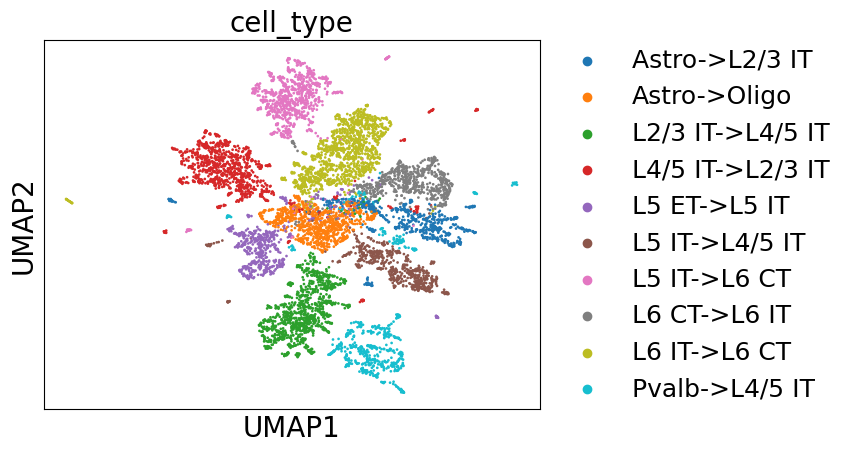

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


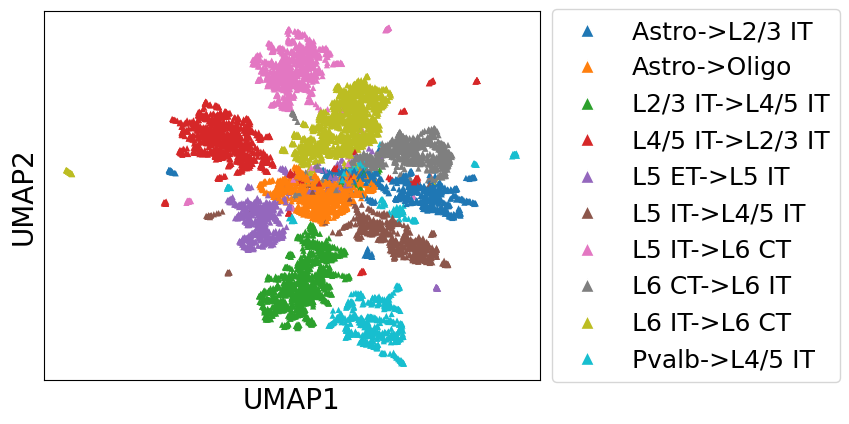

In [89]:
def plot(adata,color='cell_type',select_type_number=None,select_type=None):
    assert not ((select_type is None and select_type_number is None) and (select_type is not None and select_type_number is not None))
    
    if select_type_number is not None:
        unique=np.unique(adata.obs['cell_type'],return_counts=True)
        args = np.argsort(-unique[1])[:select_type_number]
        select_type = unique[0][args]
    print("selecting edge types:", select_type)
    
    flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
    adata_filtered=adata[flag,:]

    sc.pp.scale(adata_filtered)
    sc.tl.pca(adata_filtered, n_comps=50)
    sc.pp.neighbors(adata_filtered)  # Compute the neighborhood graph
    sc.tl.umap(adata_filtered)  # Compute UMAP
    #sc.pl.umap(adata_filtered,color="cell_type")
    return adata_filtered
adatax=plot(adata,select_type_number=10)
adatax.write_h5ad("./adatax.h5ad")

import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plotx(adata, marker="^"):
    # Generate the UMAP plot with smaller points (e.g., size=10)
    sc.pl.umap(adata, color='cell_type', title="", show=False, save=False, size=3)

    # Access the current figure and axis
    fig = plt.gcf()
    ax = plt.gca()

    # Get the scatter plot and update the marker style
    for artist in ax.collections:
        artist.set_paths([plt.matplotlib.markers.MarkerStyle(marker).get_path()])
        artist.set_offsets(artist.get_offsets())  # Force redraw of the updated markers

    # Modify the legend markers to match the plot markers and move the legend to the right
    handles, labels = ax.get_legend_handles_labels()
    new_handles = [Line2D([0], [0], marker=marker, color='w', markerfacecolor=h.get_facecolor()[0], markersize=10) for h in handles]
    
    ax.legend(handles=new_handles, labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))

    # Show the plot (optional)
    plt.show()

    # Save the plot with the desired filename
    fig.savefig("./figures/CCI_UMAP.pdf", bbox_inches='tight')

# Example call to the function
plotx(adatax)

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


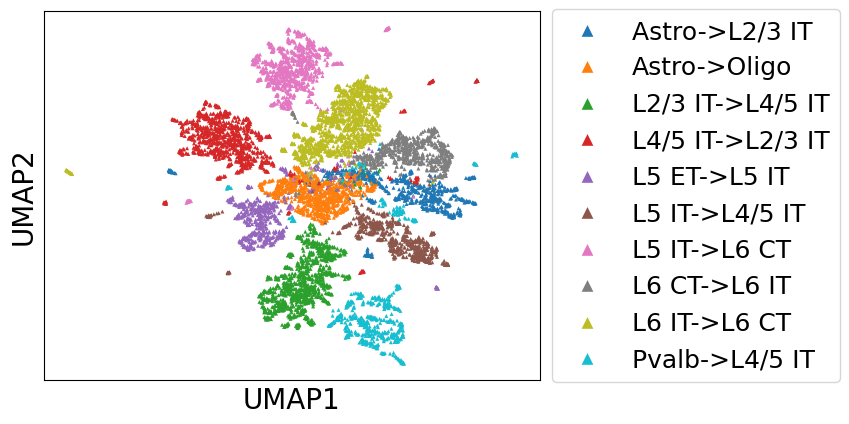

In [92]:
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plotx(adata, marker="^"):
    # Generate the UMAP plot with smaller points (e.g., size=10)
    sc.pl.umap(adata, color='cell_type', title="", show=False, save=False, size=2)

    # Access the current figure and axis
    fig = plt.gcf()
    ax = plt.gca()

    # Get the scatter plot and update the marker style
    for artist in ax.collections:
        artist.set_paths([plt.matplotlib.markers.MarkerStyle(marker).get_path()])
        artist.set_offsets(artist.get_offsets())  # Force redraw of the updated markers

    # Modify the legend markers to match the plot markers and move the legend to the right
    handles, labels = ax.get_legend_handles_labels()
    new_handles = [Line2D([0], [0], marker=marker, color='w', markerfacecolor=h.get_facecolor()[0], markersize=10) for h in handles]
    
    ax.legend(handles=new_handles, labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))

    # Show the plot (optional)
    plt.show()

    # Save the plot with the desired filename
    fig.savefig("./figures/CCI_UMAP.pdf", bbox_inches='tight')

# Example call to the function
plotx(adatax)

selecting edge types: ['L6 IT->L6 CT' 'L2/3 IT->L4/5 IT' 'L4/5 IT->L2/3 IT' 'Astro->Oligo'
 'L5 IT->L6 CT' 'Pvalb->L4/5 IT' 'L6 CT->L6 IT' 'Astro->L2/3 IT'
 'L5 IT->L4/5 IT' 'L5 ET->L5 IT' 'L6 CT->L5 IT' 'Lamp5->L2/3 IT'
 'L4/5 IT->L5 IT' 'L2/3 IT->Astro' 'L6b->L6 CT']


/tmp/ipykernel_401128/2794902925.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wa

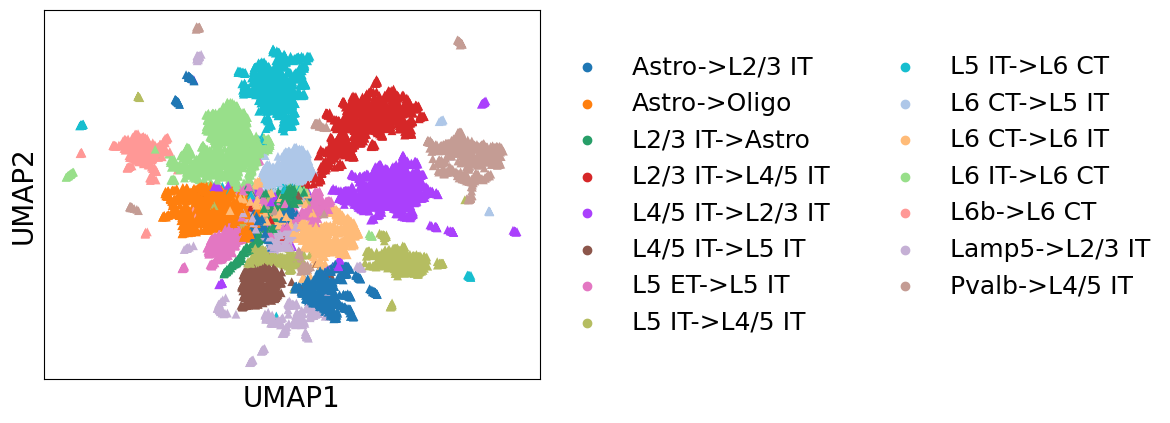

In [58]:
plot(adata,select_type_number=15)

/tmp/ipykernel_401700/4114958970.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]


selecting edge types: ['L6 IT->L6 CT' 'L2/3 IT->L4/5 IT' 'L4/5 IT->L2/3 IT' 'Astro->Oligo'
 'L5 IT->L6 CT' 'Pvalb->L4/5 IT' 'L6 CT->L6 IT' 'Astro->L2/3 IT'
 'L5 IT->L4/5 IT' 'L5 ET->L5 IT' 'L6 CT->L5 IT' 'Lamp5->L2/3 IT'
 'L4/5 IT->L5 IT' 'L2/3 IT->Astro' 'L6b->L6 CT' 'Astro->L4/5 IT'
 'L6 IT->L5 IT' 'Pvalb->L2/3 IT' 'Oligo->Astro' 'L5 IT->L6 IT'
 'Astro->Endo' 'Endo->Peri' 'Peri->Endo' 'L5 IT->L5 ET' 'L6 CT->Oligo']


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


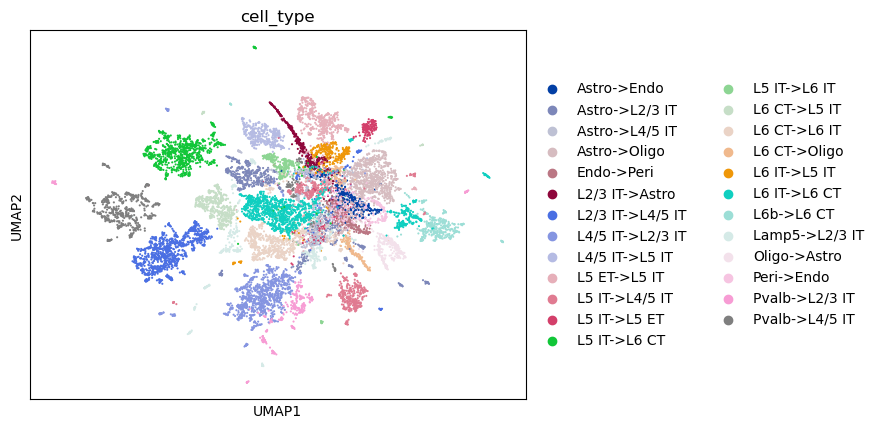

selecting edge types: ['L6 IT->L6 CT' 'L2/3 IT->L4/5 IT' 'L4/5 IT->L2/3 IT' 'Astro->Oligo'
 'L5 IT->L6 CT' 'Pvalb->L4/5 IT' 'L6 CT->L6 IT' 'Astro->L2/3 IT'
 'L5 IT->L4/5 IT' 'L5 ET->L5 IT' 'L6 CT->L5 IT' 'Lamp5->L2/3 IT'
 'L4/5 IT->L5 IT' 'L2/3 IT->Astro' 'L6b->L6 CT' 'Astro->L4/5 IT'
 'L6 IT->L5 IT' 'Pvalb->L2/3 IT' 'Oligo->Astro' 'L5 IT->L6 IT'
 'Astro->Endo' 'Endo->Peri' 'Peri->Endo' 'L5 IT->L5 ET' 'L6 CT->Oligo'
 'Micro->L2/3 IT' 'Peri->L4/5 IT' 'Endo->Astro' 'L6 CT->L6b'
 'Sst->L4/5 IT']


/tmp/ipykernel_401700/4114958970.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wa

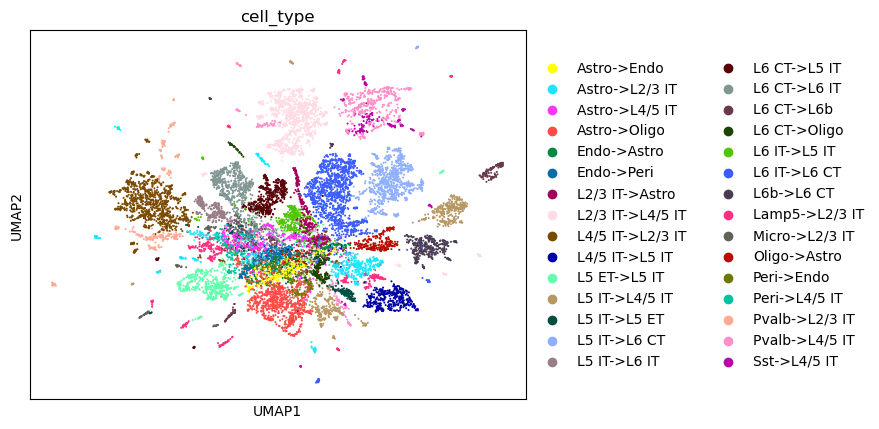

selecting edge types: ['L6 IT->L6 CT' 'L2/3 IT->L4/5 IT' 'L4/5 IT->L2/3 IT' 'Astro->Oligo'
 'L5 IT->L6 CT' 'Pvalb->L4/5 IT' 'L6 CT->L6 IT' 'Astro->L2/3 IT'
 'L5 IT->L4/5 IT' 'L5 ET->L5 IT' 'L6 CT->L5 IT' 'Lamp5->L2/3 IT'
 'L4/5 IT->L5 IT' 'L2/3 IT->Astro' 'L6b->L6 CT' 'Astro->L4/5 IT'
 'L6 IT->L5 IT' 'Pvalb->L2/3 IT' 'Oligo->Astro' 'L5 IT->L6 IT']


/tmp/ipykernel_401700/4114958970.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


KeyboardInterrupt: 

In [7]:
plot(adata,select_type_number=25)
adata_filtered=plot(adata,select_type_number=30)
plot(adata,select_type_number=20,color="cell_types_from")
plot(adata,select_type_number=20,color='cell_type_target')
plot(adata,select_type_number=20,color="distance")

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


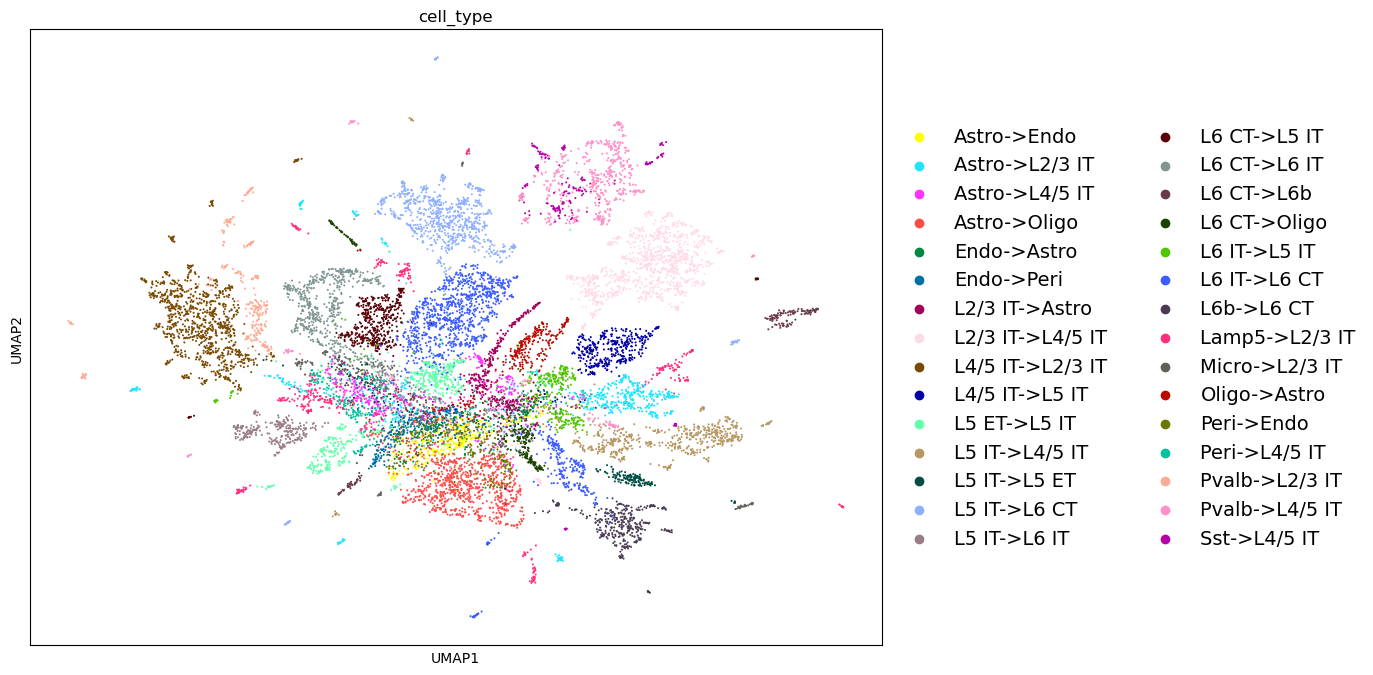

In [7]:
fig, ax = plt.subplots(figsize=(11, 8))
sc.pl.umap(adata_filtered, color='cell_type',ax=ax,legend_fontsize=14)

/tmp/ipykernel_2662730/4114958970.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]


selecting edge types: ['L6 IT->L6 CT' 'L2/3 IT->L4/5 IT' 'L4/5 IT->L2/3 IT' 'Astro->Oligo'
 'L5 IT->L6 CT' 'Pvalb->L4/5 IT' 'L6 CT->L6 IT' 'Astro->L2/3 IT'
 'L5 IT->L4/5 IT' 'L5 ET->L5 IT']


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


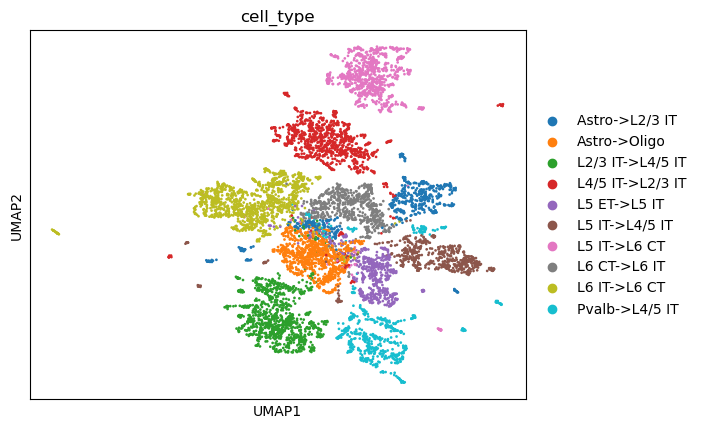

AnnData object with n_obs × n_vars = 8025 × 254
    obs: 'cell_type', 'cell_types_from', 'cell_type_target', 'from_position_x', 'from_position_y', 'to_position_x', 'to_position_y', 'distance', 'loss'
    var: 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'y', 'attention_score', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [7]:
plot(adata,select_type_number=10)

selecting edge types: ['L6 IT->L6 CT' 'L2/3 IT->L4/5 IT' 'L4/5 IT->L2/3 IT' 'Astro->Oligo'
 'L5 IT->L6 CT' 'Pvalb->L4/5 IT' 'L6 CT->L6 IT' 'Astro->L2/3 IT'
 'L5 IT->L4/5 IT' 'L5 ET->L5 IT' 'L6 CT->L5 IT' 'Lamp5->L2/3 IT'
 'L4/5 IT->L5 IT' 'L2/3 IT->Astro' 'L6b->L6 CT']


/tmp/ipykernel_2662730/4114958970.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/w

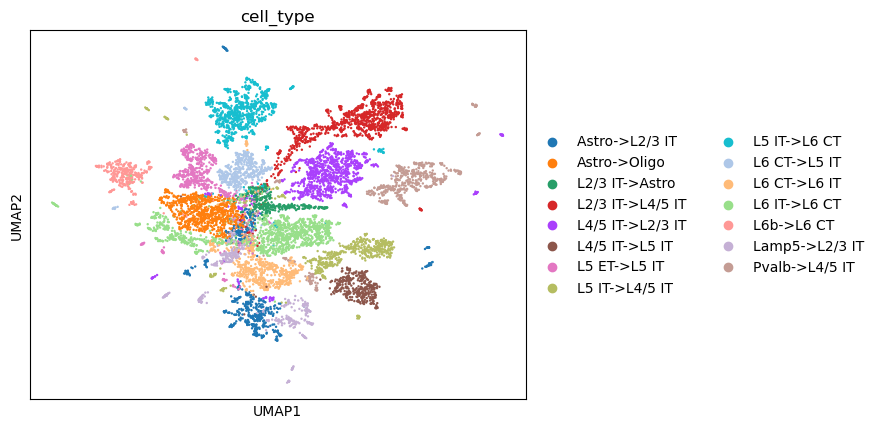

AnnData object with n_obs × n_vars = 10048 × 254
    obs: 'cell_type', 'cell_types_from', 'cell_type_target', 'from_position_x', 'from_position_y', 'to_position_x', 'to_position_y', 'distance', 'loss'
    var: 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'y', 'attention_score', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [8]:
plot(adata,select_type_number=15)

selecting edge types: ['L6 IT->L6 CT' 'L2/3 IT->L4/5 IT' 'L4/5 IT->L2/3 IT' 'Astro->Oligo'
 'L5 IT->L6 CT' 'Pvalb->L4/5 IT' 'L6 CT->L6 IT' 'Astro->L2/3 IT'
 'L5 IT->L4/5 IT' 'L5 ET->L5 IT' 'L6 CT->L5 IT' 'Lamp5->L2/3 IT'
 'L4/5 IT->L5 IT' 'L2/3 IT->Astro' 'L6b->L6 CT' 'Astro->L4/5 IT'
 'L6 IT->L5 IT' 'Pvalb->L2/3 IT' 'Oligo->Astro' 'L5 IT->L6 IT']


/tmp/ipykernel_2662730/4114958970.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/w

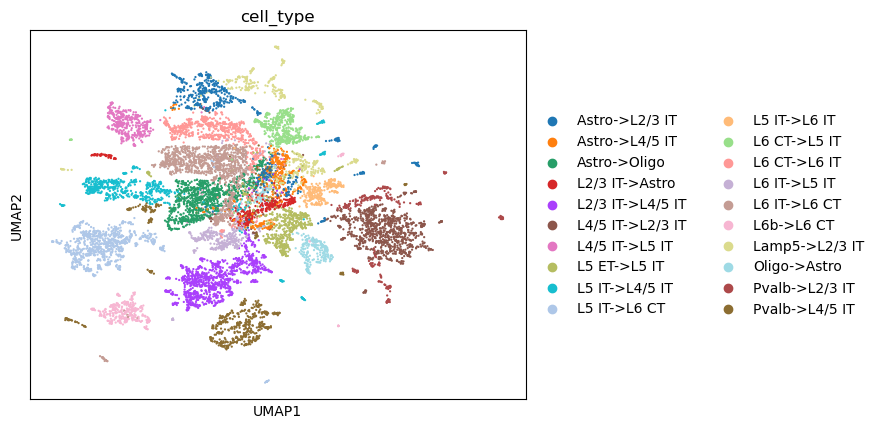

AnnData object with n_obs × n_vars = 11620 × 254
    obs: 'cell_type', 'cell_types_from', 'cell_type_target', 'from_position_x', 'from_position_y', 'to_position_x', 'to_position_y', 'distance', 'loss'
    var: 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'y', 'attention_score', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [9]:
plot(adata,select_type_number=20)

In [9]:
unique=np.unique(adata.obs['cell_type'],return_counts=True)
unique_arg=np.argsort(-unique[1])
print(unique[0][unique_arg].tolist(),unique[1][unique_arg].tolist())

['L6 IT->L6 CT', 'L2/3 IT->L4/5 IT', 'L4/5 IT->L2/3 IT', 'Astro->Oligo', 'L5 IT->L6 CT', 'Pvalb->L4/5 IT', 'L6 CT->L6 IT', 'Astro->L2/3 IT', 'L5 IT->L4/5 IT', 'L5 ET->L5 IT', 'L6 CT->L5 IT', 'Lamp5->L2/3 IT', 'L4/5 IT->L5 IT', 'L2/3 IT->Astro', 'L6b->L6 CT', 'Astro->L4/5 IT', 'L6 IT->L5 IT', 'Pvalb->L2/3 IT', 'Oligo->Astro', 'L5 IT->L6 IT', 'Astro->Endo', 'Endo->Peri', 'Peri->Endo', 'L5 IT->L5 ET', 'L6 CT->Oligo', 'Micro->L2/3 IT', 'Peri->L4/5 IT', 'Endo->Astro', 'L6 CT->L6b', 'Sst->L4/5 IT', 'L6b->L6 IT', 'L6b->Oligo', 'Endo->L2/3 IT', 'L5 IT->Oligo', 'Vip->L2/3 IT', 'PVM->Endo', 'Endo->Micro', 'OPC->L2/3 IT', 'Endo->VLMC', 'L6 CT->Pvalb', 'L6 IT->Oligo', 'L5 IT->Astro', 'L4/5 IT->Pvalb', 'Oligo->L2/3 IT', 'OPC->Oligo', 'Endo->Oligo', 'Oligo->L6 CT', 'Oligo->L4/5 IT', 'L6b->Astro', 'L2/3 IT->Endo', 'L4/5 IT->Astro', 'Endo->PVM', 'L6 IT Car3->L6 CT', 'L6 CT->Astro', 'L6 IT->L6b', 'L6 IT->Astro', 'Pvalb->Astro', 'L5 ET->L4/5 IT', 'L4/5 IT->L5 ET', 'Astro->OPC', 'L5 ET->L6 CT', 'L6 CT->L

In [10]:
desired_CCC_type='Astro->Oligo'#'Astro__Oligo'#'Oligo__Astro'#'Astro__L2/3 IT'#'Oligo__Astro'#'Endo__Oligo'#'Endo__Astro'#'Endo__Astro'#'Astro__L2/3 IT'#'Astro__L2/3 IT'#'Astro__Oligo'#'Endo__Astro'#'Astro__L2/3 IT'#'Endo__Oligo'#'Endo__Astro'#'Micro__Endo'#'Astro__Oligo'#'OPC__L2/3 IT'#'Micro__L4/5 IT'#'OPC__L4/5 IT'#'Micro__L4/5 IT','Micro__L6 CT'

def get_type_adata(sample,cell_type_pair,select=20):
    adata_type=read_data(sample,select=select,choose_specific_type=cell_type_pair)
    adata_type.obs["is_target_interaction"]=[True for i in range(adata_type.shape[0])]
    adata_type.obs["is_target_interaction_str"]=[True for i in range(adata_type.shape[0])]
    print(adata_type)
    return adata_type

adata_type=get_type_adata(sample,select=10,cell_type_pair=desired_CCC_type)#get_type_adata(adata,desired_CCC_type)

torch.Size([6137, 49, 254])
torch.return_types.topk(
values=tensor([[0.1652, 0.1395, 0.0886,  ..., 0.0321, 0.0255, 0.0247],
        [0.1286, 0.1173, 0.1142,  ..., 0.0274, 0.0223, 0.0205],
        [0.1366, 0.0889, 0.0804,  ..., 0.0326, 0.0311, 0.0310],
        ...,
        [0.2374, 0.0818, 0.0393,  ..., 0.0228, 0.0193, 0.0188],
        [0.1332, 0.1058, 0.1016,  ..., 0.0312, 0.0293, 0.0274],
        [0.0592, 0.0571, 0.0564,  ..., 0.0387, 0.0324, 0.0286]]),
indices=tensor([[ 1, 26,  2,  ..., 15, 29,  9],
        [ 0, 18, 19,  ..., 24, 46,  3],
        [46,  0, 35,  ..., 43, 27,  2],
        ...,
        [ 0,  1,  3,  ..., 25,  5, 29],
        [34, 13, 47,  ...,  0, 26, 18],
        [29, 22, 14,  ...,  1, 20, 48]]))
number of cell types in this sample: (array(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Micro', 'OPC',
       'Oligo', 'PVM', 'Peri', 'Pvalb', 'SMC', 'Sncg', 'Sst', 'VLMC',
       'Vip', 'other'], 

/tmp/ipykernel_2183304/2701594388.py:88: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  adata=adata[(adata.obs['loss']<loss_threshold)&flags,:]
/tmp/ipykernel_2183304/1397021259.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_type.obs["is_target_interaction"]=[True for i in range(adata_type.shape[0])]


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


(1578, 254)


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


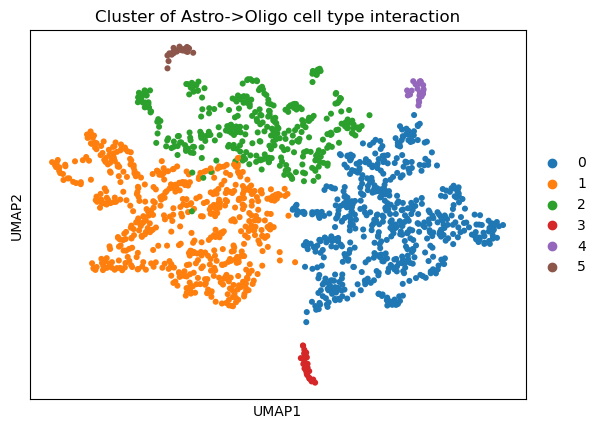

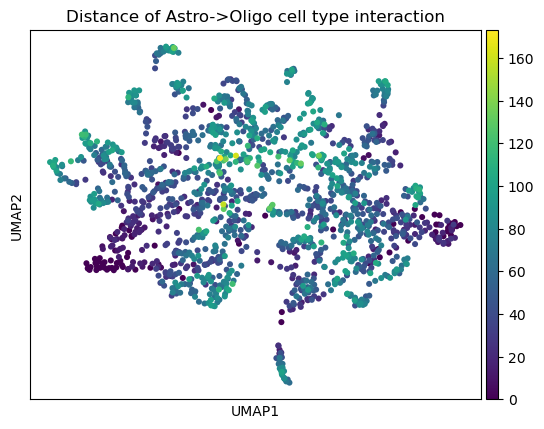

In [11]:
def cluster_and_plot(adata_original,desired_CCC_type):
    adata=adata_original[adata_original.obs["is_target_interaction"]==True]
    print(adata.shape)
    #sc.pp.scale(adata)
    # PCA
    sc.tl.pca(adata)
    # Neighborhood Graph
    sc.pp.neighbors(adata)
    # Clustering
    sc.tl.leiden(adata,resolution=0.15)  # or sc.tl.louvain(adata)
    # Visualization
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='leiden',title="Cluster of "+desired_CCC_type+" cell type interaction")
    sc.pl.umap(adata, color='distance',title="Distance of "+desired_CCC_type+" cell type interaction")
    return np.array(adata.obs['leiden'].values)
leiden=cluster_and_plot(adata_type[adata_type.obs["is_target_interaction"]],desired_CCC_type)

In [12]:
def merge_group(adata_type,groups):
    groups1=[]
    cnt=0
    for i in range(len(adata_type.obs["is_target_interaction"])):
        if adata_type.obs["is_target_interaction"][i]==False:
            groups1.append("-1")
        else:
            groups1.append(groups[cnt])
            cnt=cnt+1
    assert cnt==len(groups)
    adata_type.obs["group"]=groups1
    return adata_type

adata_type=merge_group(adata_type,leiden)
print(adata_type)

AnnData object with n_obs × n_vars = 1578 × 254
    obs: 'cell_type', 'cell_types_from', 'cell_type_target', 'from_position_x', 'from_position_y', 'to_position_x', 'to_position_y', 'distance', 'loss', 'is_target_interaction', 'is_target_interaction_str', 'group'
    obsm: 'y', 'attention_score'


/tmp/ipykernel_2183304/1162171487.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata_type.obs["is_target_interaction"][i]==False:


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_utils.py:715: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


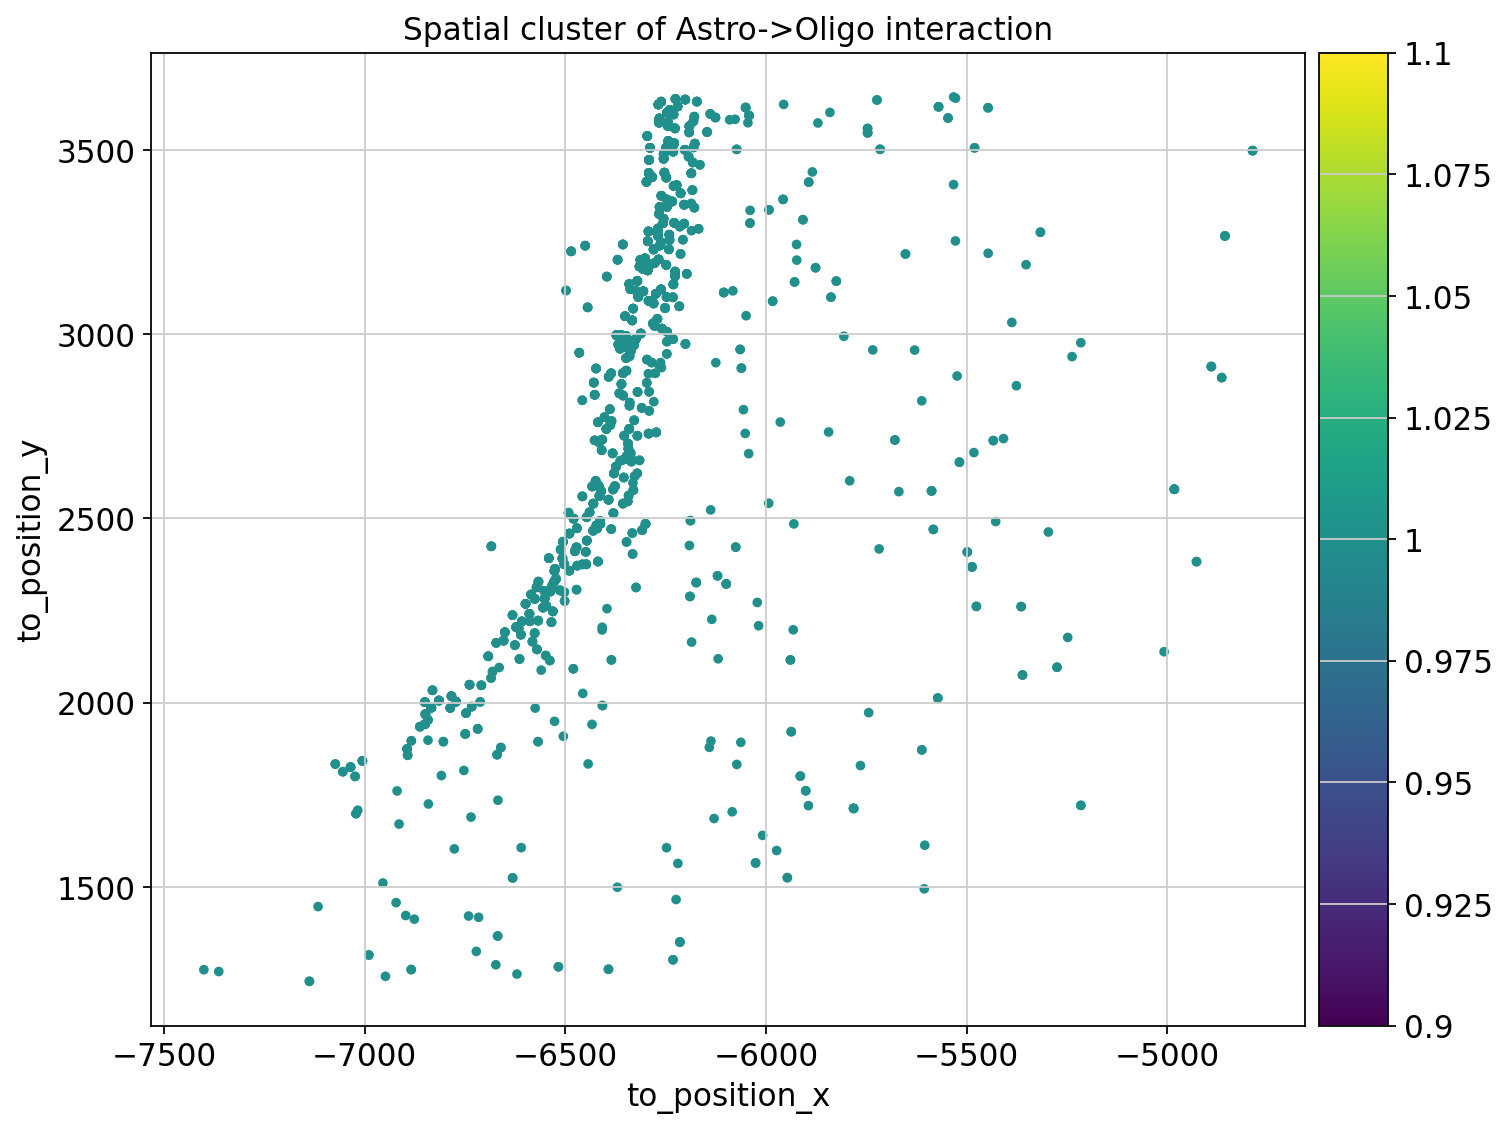

/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_utils.py:431: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


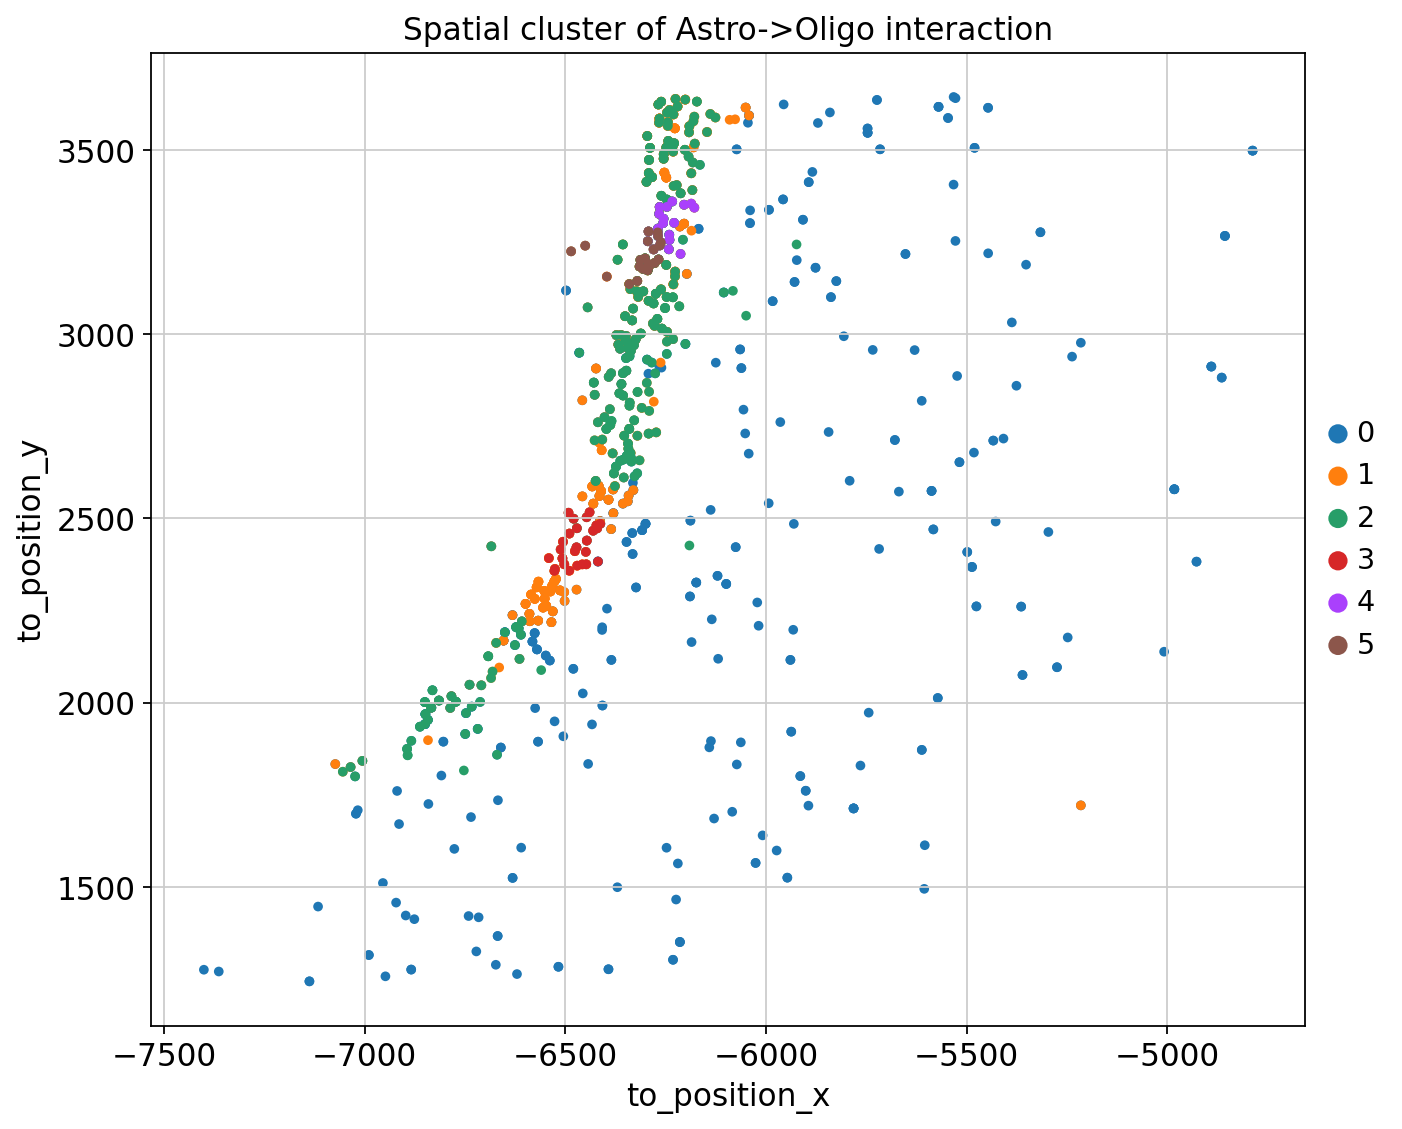

In [13]:
def spatial_visualize_type(adata,interaction_name):
    sc.set_figure_params(figsize=(8, 8))  # Adjust figure size as needed
    sc.pl.scatter(
        adata,
        x='to_position_x',#'position_x',
        y='to_position_y',#'position_y',
        color="is_target_interaction",
        title=f"Spatial cluster of {interaction_name} interaction"
    )
    
    adata1=adata[adata.obs["is_target_interaction"]]
    sc.set_figure_params(figsize=(8, 8))  # Adjust figure size as needed
    sc.pl.scatter(
        adata1,
        x='to_position_x',#'position_x',
        y='to_position_y',#'position_y',
        color='group',
        title=f"Spatial cluster of {interaction_name} interaction"
    )
spatial_visualize_type(adata_type,desired_CCC_type)

In [14]:
def filter_same_target_cell(adata_type):
    unique_y=[]
    group_y=[]
    
    useful_index=[]
    
    for i in range(adata_type.shape[0]):
        if len(unique_y)==0:
            unique_y.append(adata_type.obsm["y"][i,:])
            group_y.append(adata_type.obs["group"][i])
            useful_index.append(i)
            continue
        if np.sum(adata_type.obsm["y"][i,:]-unique_y[-1])==0:
            groupi=adata_type.obs["group"][i]
            if int(groupi)>=int(group_y[-1]) and int(group_y[-1])>0:
                group_y[-1]=groupi
                useful_index[-1]=i
            continue
        unique_y.append(adata_type.obsm["y"][i,:])
        group_y.append(adata_type.obs["group"][i])
        useful_index.append(i)
    
    adata_new=adata_type[np.array(useful_index)]
    adata_new.obs["group"]=group_y
    return adata_new        

adata_type1=filter_same_target_cell(adata_type)
print(adata_type,adata_type1)

AnnData object with n_obs × n_vars = 1578 × 254
    obs: 'cell_type', 'cell_types_from', 'cell_type_target', 'from_position_x', 'from_position_y', 'to_position_x', 'to_position_y', 'distance', 'loss', 'is_target_interaction', 'is_target_interaction_str', 'group'
    obsm: 'y', 'attention_score' AnnData object with n_obs × n_vars = 494 × 254
    obs: 'cell_type', 'cell_types_from', 'cell_type_target', 'from_position_x', 'from_position_y', 'to_position_x', 'to_position_y', 'distance', 'loss', 'is_target_interaction', 'is_target_interaction_str', 'group'
    obsm: 'y', 'attention_score'


/tmp/ipykernel_2183304/3681325696.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  group_y.append(adata_type.obs["group"][i])
/tmp/ipykernel_2183304/3681325696.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  groupi=adata_type.obs["group"][i]
/tmp/ipykernel_2183304/3681325696.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  group_y.append(adata_type.obs["group"][i])
/tmp/ipykernel_2183304/3681325696.py:24: ImplicitModifi

/tmp/ipykernel_2183304/2135199323.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata0.obs["group"]=["cluster_"+x for x in adata0.obs["group"]]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


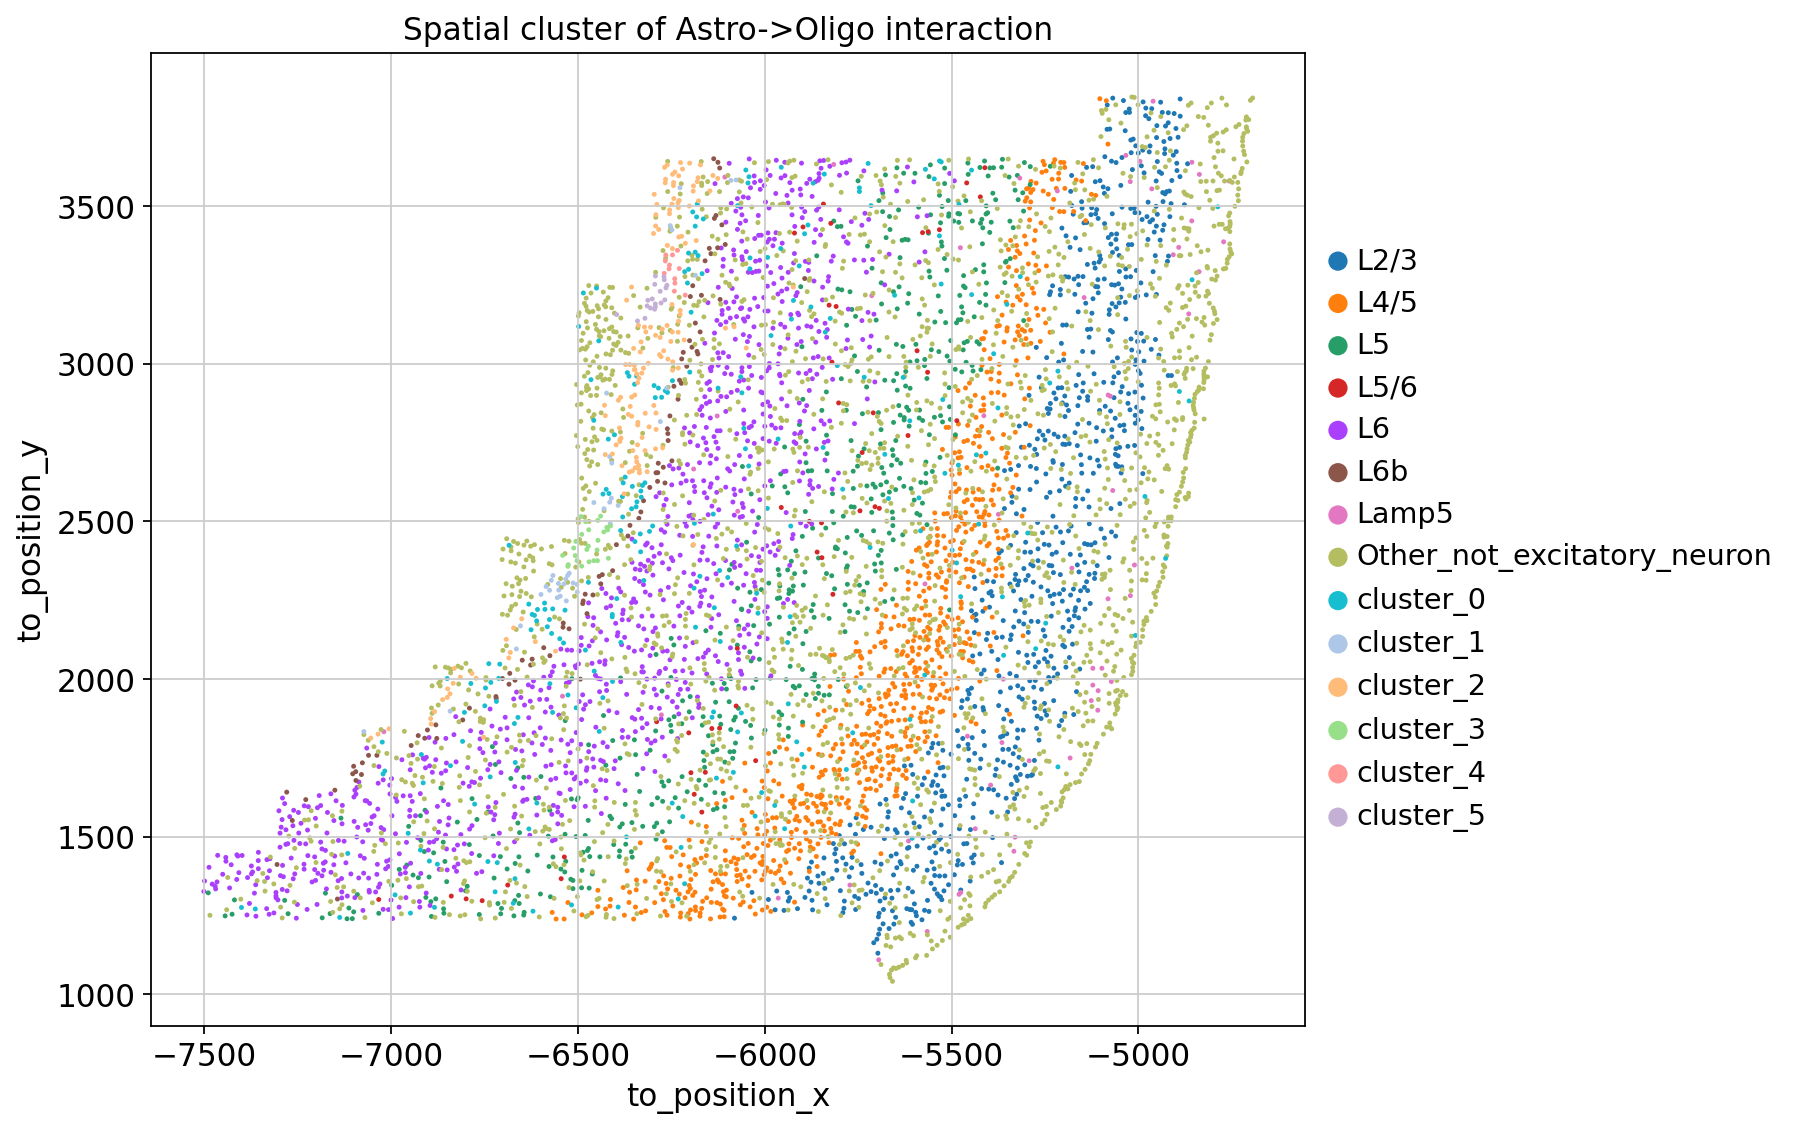

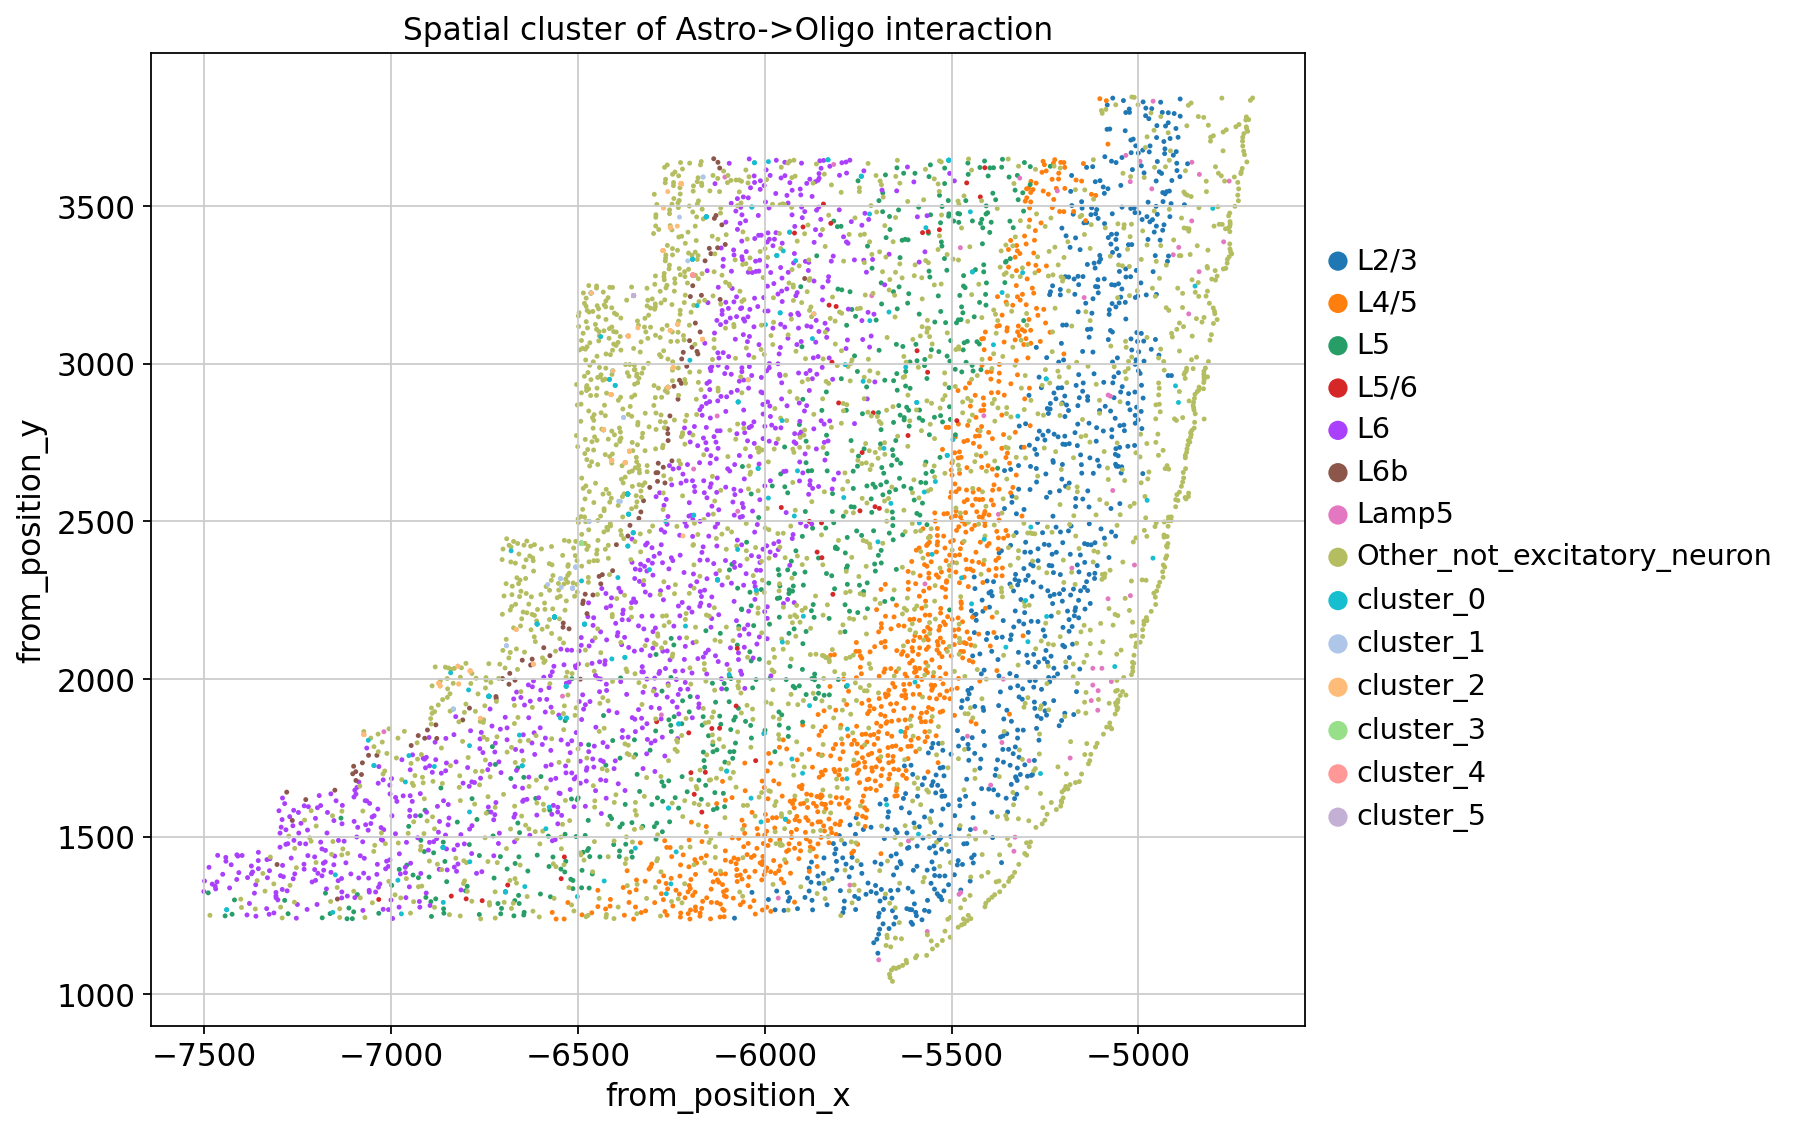

/tmp/ipykernel_2183304/2135199323.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata0.obs["group"]=["cluster_"+x for x in adata0.obs["group"]]


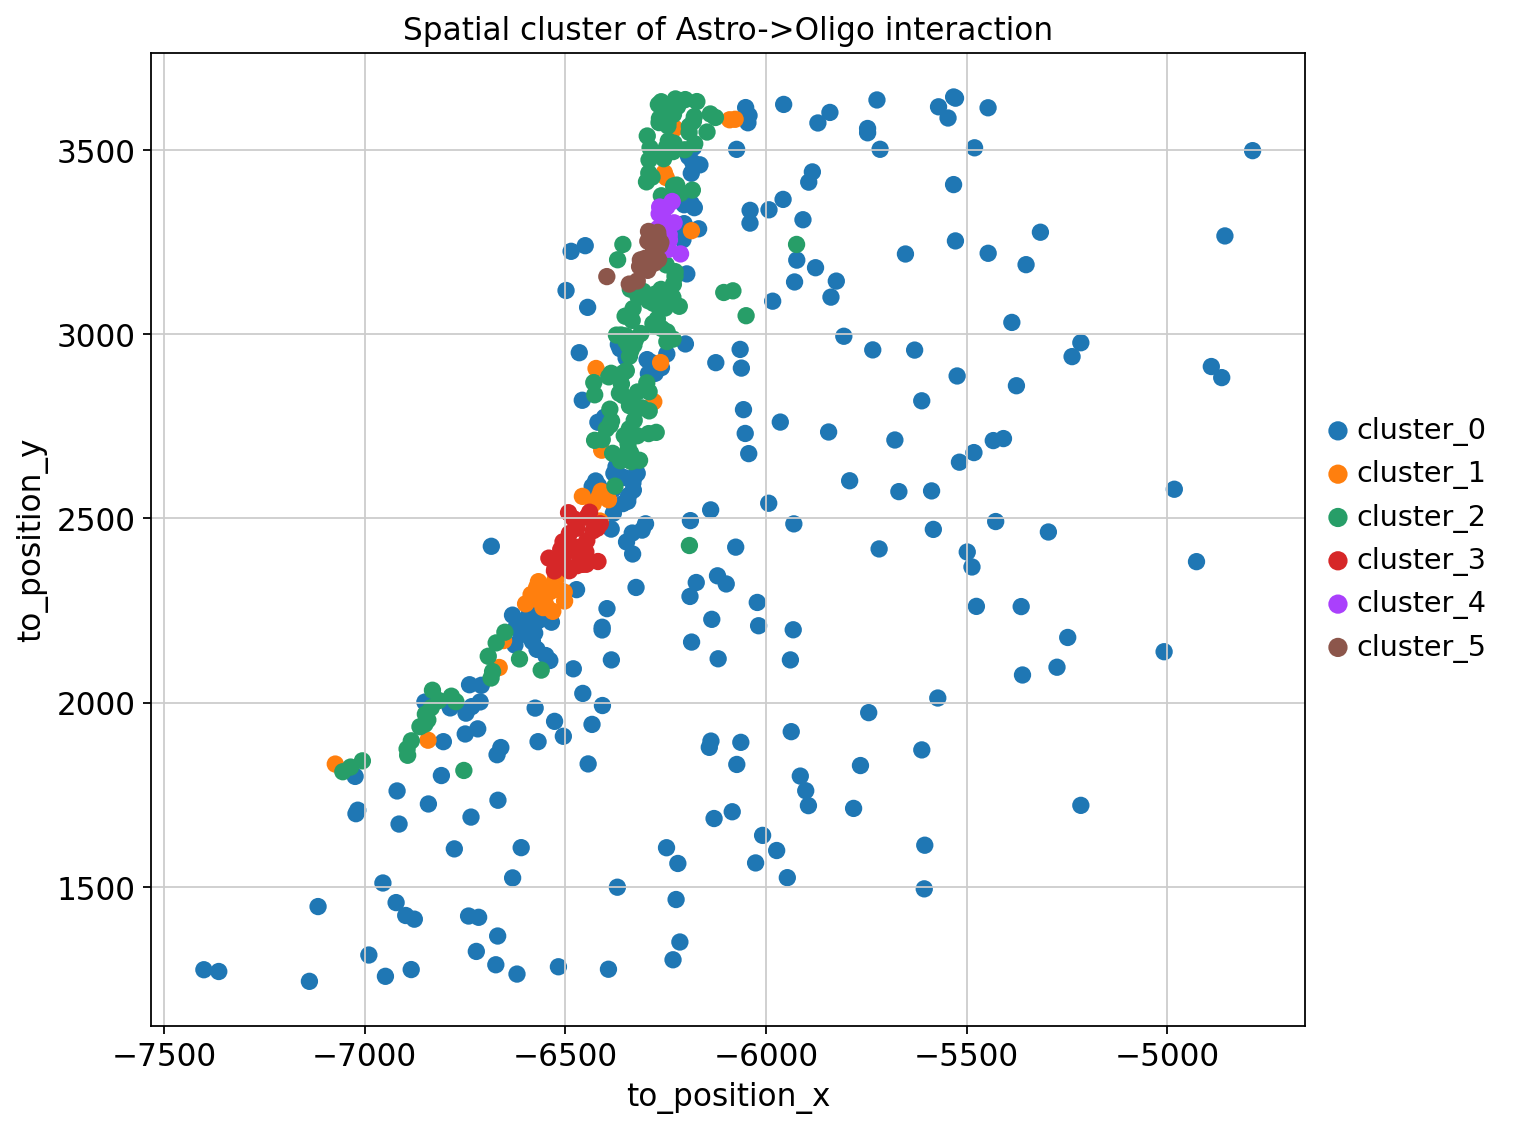

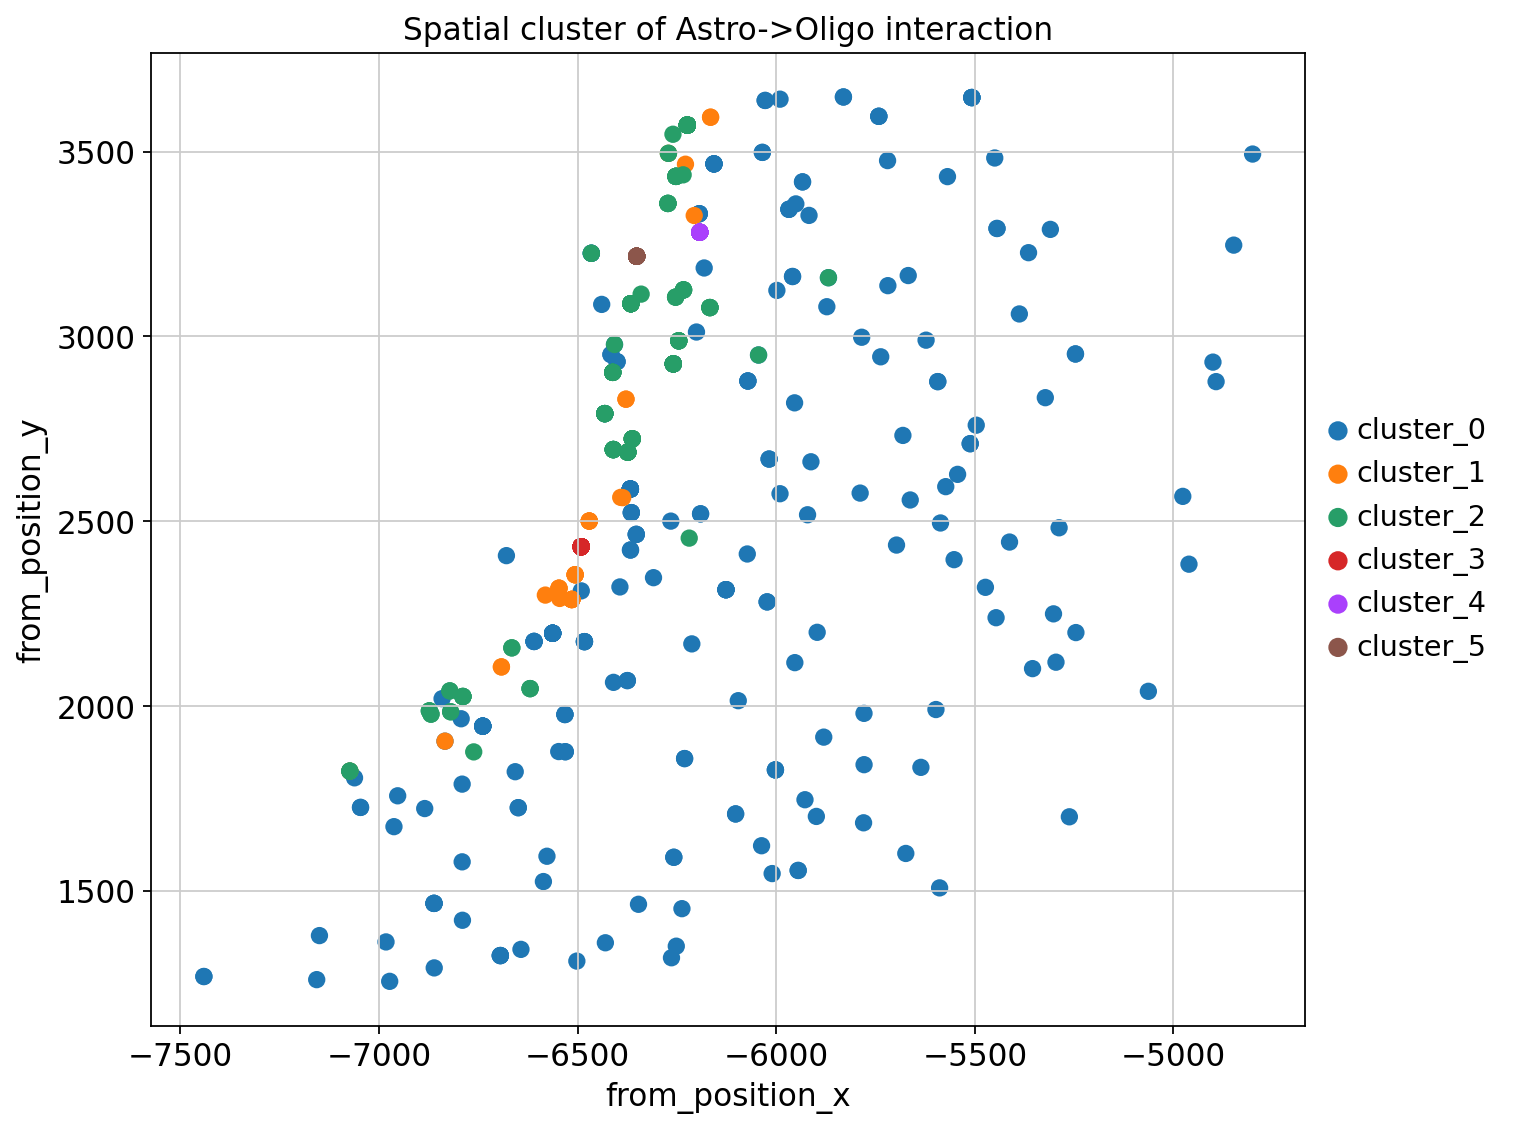

In [15]:
def spatial_visualize_type1(adata,interaction_name,plot_all=True):
    adata0=adata[adata.obs["group"]!="-1"]#.copy()#
    adata0.obs["group"]=["cluster_"+x for x in adata0.obs["group"]]
    adata1=ad.concat([adata_position[adata_position.obs['cell_type']!=desired_CCC_type.split("->")[1],:],adata0],axis=0) if plot_all else adata0
    adata2=ad.concat([adata_position[adata_position.obs['cell_type']!=desired_CCC_type.split("->")[0],:],adata0],axis=0) if plot_all else adata0
    sc.set_figure_params(figsize=(8, 8))  # Adjust figure size as needed
    sc.pl.scatter(
        adata1,
        x='to_position_x',#'position_x',
        y='to_position_y',#'position_y',
        color="group",
        title=f"Spatial cluster of {interaction_name} interaction"
    )
    sc.pl.scatter(
        adata2,
        x='from_position_x',#'position_x',
        y='from_position_y',#'position_y',
        color="group",
        title=f"Spatial cluster of {interaction_name} interaction"
    )
spatial_visualize_type1(adata_type1,desired_CCC_type)
spatial_visualize_type1(adata_type1,desired_CCC_type,False)

In [16]:
def filter_extreme_percentiles(adata, select, percentile_low=2, percentile_high=98):
    # Extracting and flattening the list of gene tuples
    gene_tuples = adata.uns['rank_genes_groups']['names'][:select]
    gene_names = [gene for tup in gene_tuples for gene in tup]  # Flatten the list of tuples into a list of gene names
    print(adata.uns['rank_genes_groups']['names'][:select],gene_names)
    # Remove duplicates if necessary
    gene_names = list(set(gene_names))

    # Data structure to keep track of which indices to keep
    indices_to_keep = set(range(adata.shape[0]))

    # Iterate over each gene, filter rows based on the percentiles
    for gene in gene_names:
        if gene in adata.var_names:
            # Calculate the low and high percentile values
            values = adata.obs_vector(gene)  # Get a numpy array of the values for this gene
            low_threshold = np.percentile(values, percentile_low)
            high_threshold = np.percentile(values, percentile_high)

            # Determine indices that fall outside the low and high thresholds
            filtered_indices = np.where((values >= low_threshold) & (values <= high_threshold))[0]
            indices_to_keep.intersection_update(filtered_indices)
        else:
            print(f"Gene {gene} not found in the variable names.")

    # Filter the adata to keep only the desired rows
    adata = adata[list(indices_to_keep), :]

    return adata

         Falling back to preprocessing with `sc.pp.pca` and default params.


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


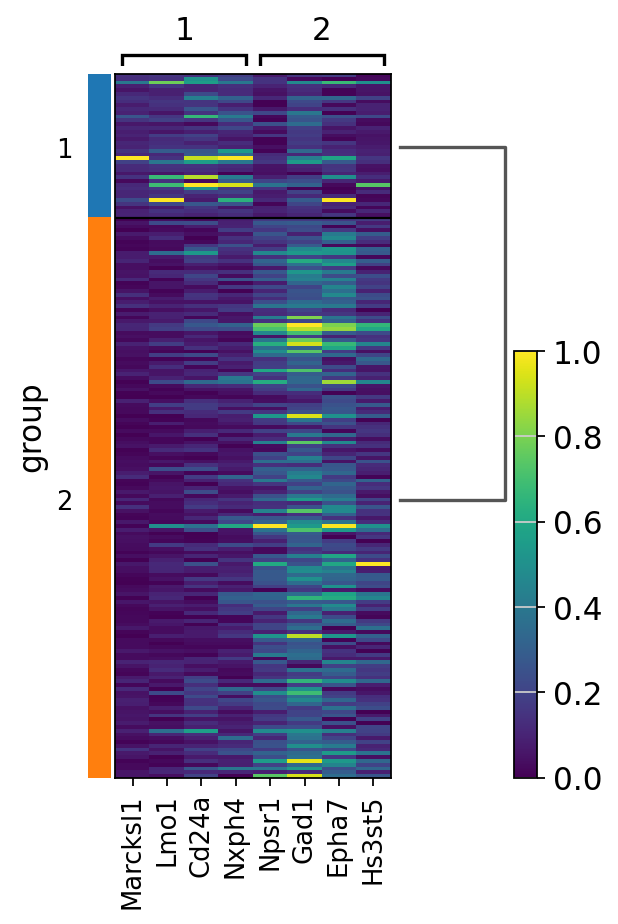

AnnData object with n_obs × n_vars = 186 × 254
    obs: 'cell_type', 'cell_types_from', 'cell_type_target', 'from_position_x', 'from_position_y', 'to_position_x', 'to_position_y', 'distance', 'loss', 'is_target_interaction', 'is_target_interaction_str', 'group'
    uns: 'rank_genes_groups', 'group_colors', 'dendrogram_group'
    obsm: 'X_pca'
         Falling back to preprocessing with `sc.pp.pca` and default params.


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


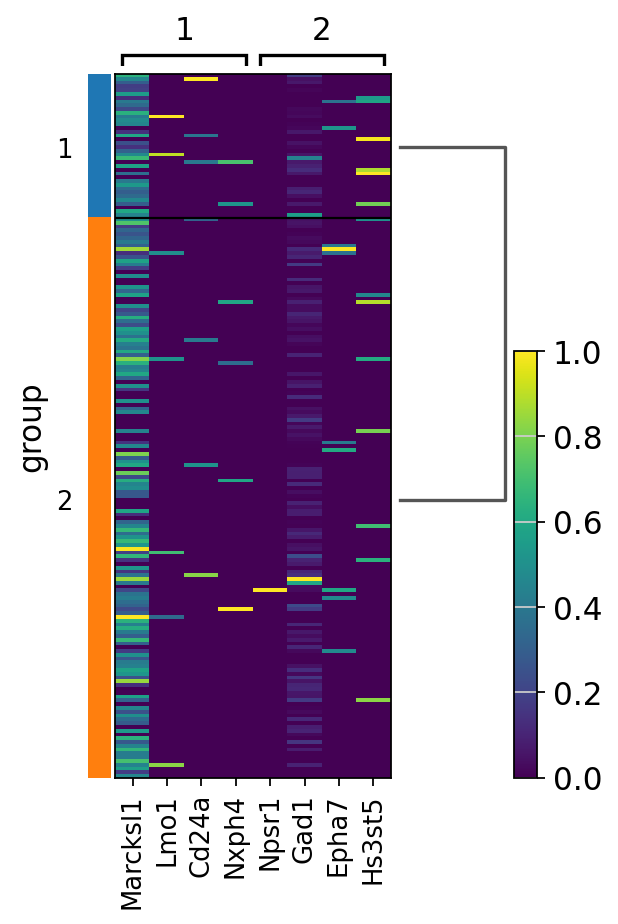

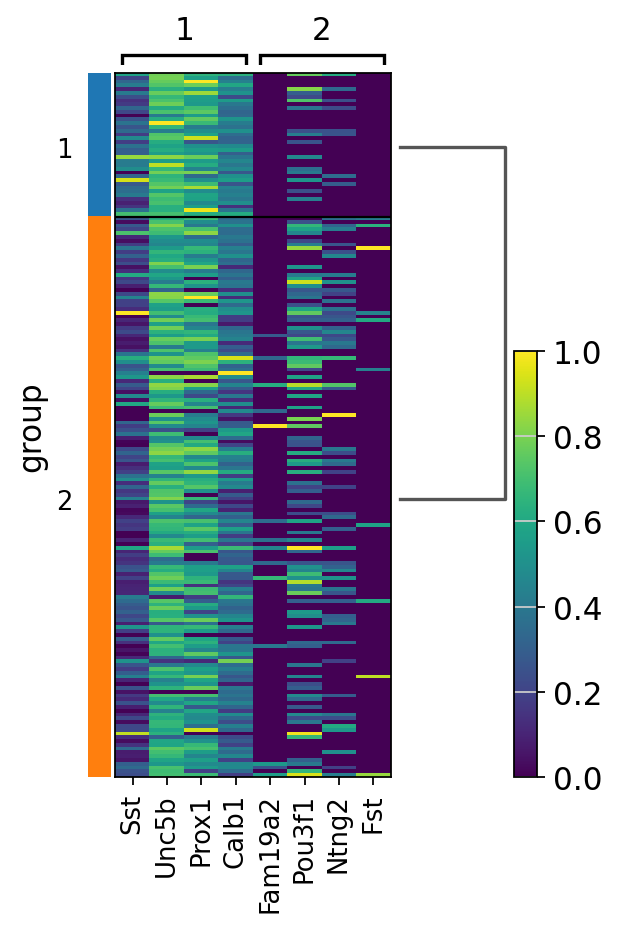

In [17]:
select=4

adata_type_attention=ad.AnnData(X=np.abs(adata_type1.obsm["attention_score"]), obs=adata_type1.obs)
adata_type_attention=adata_type_attention[adata_type_attention.obs["group"].isin(["2","1"])]#,"2","2","3"
adata_type_attention.var_names=genes
sc.tl.rank_genes_groups(adata_type_attention, 'group', method='t-test_overestim_var')#sc.tl.rank_genes_groups(adata_type_attention, 'group', method='t-test')
#adata_type_attention=filter_extreme_percentiles(adata_type_attention,select)
sc.pl.rank_genes_groups_heatmap(adata_type_attention, n_genes=select, show_gene_labels=True,standard_scale='var', cmap='viridis')
print(adata_type_attention)

adata_type_y=ad.AnnData(X=adata_type1.obsm["y"], obs=adata_type1.obs)
adata_type_y=adata_type_y[adata_type_y.obs["group"].isin(["1","2"])]#,"2","3"
adata_type_y.var_names=genes
sc.tl.rank_genes_groups(adata_type_y, 'group', method='t-test_overestim_var')
adata_type_y.uns['rank_genes_groups']=adata_type_attention.uns['rank_genes_groups']
#adata_type_y=filter_extreme_percentiles(adata_type_y,select)
sc.pl.rank_genes_groups_heatmap(adata_type_y, n_genes=select, show_gene_labels=True,standard_scale='var', cmap='viridis')

sc.tl.rank_genes_groups(adata_type_y, 'group', method='t-test_overestim_var')
#adata_type_y=filter_extreme_percentiles(adata_type_y,select)
sc.pl.rank_genes_groups_heatmap(adata_type_y, n_genes=select, show_gene_labels=True,standard_scale='var', cmap='viridis')

In [18]:
def extract_genes_and_pvals_by_group(adata, group_index, cutoff=0.05, up=True, name=None):
    # Extracting gene names and p-values from the adata object
    gene_names = adata.uns['rank_genes_groups']['names']
    p_values = adata.uns['rank_genes_groups']['pvals']
    logfoldchanges=adata.uns['rank_genes_groups']['logfoldchanges']
    p_adj=adata.uns['rank_genes_groups']['pvals_adj']
    
    # Lists to hold filtered gene names and their corresponding p-values
    filtered_genes = []
    filtered_pvals = []
    
    # Iterate through each group in the gene names and p-values
    for gene_group, pval_group,fold_group in zip(gene_names, p_adj, logfoldchanges):
        gene = gene_group[group_index]
        pval = pval_group[group_index]
        foldchange=fold_group[group_index]
        
        # Check if p-value is below the cutoff and add to the lists if it is
        #print(pval,foldchange)
        if pval < cutoff and ((foldchange>0)==up):
            filtered_genes.append(gene)
            filtered_pvals.append(pval)
    
    return filtered_genes, filtered_pvals

sig_genes1,p_val1=extract_genes_and_pvals_by_group(adata_type_y,0,0.05,False)
print(sig_genes1)
'''
sig_genes2,p_val2=extract_genes_and_pvals_by_group(adata_type_attention,0)
print(sig_genes2)

print(np.sum([x in sig_genes2 for x in sig_genes1])/len(sig_genes1))
print([x in sig_genes2 for x in sig_genes1])
'''

[]


'\nsig_genes2,p_val2=extract_genes_and_pvals_by_group(adata_type_attention,0)\nprint(sig_genes2)\n\nprint(np.sum([x in sig_genes2 for x in sig_genes1])/len(sig_genes1))\nprint([x in sig_genes2 for x in sig_genes1])\n'

In [19]:
import pandas as pd
from scipy.stats import ttest_ind

def compute_log_fold_change_pvalue(adata, name):
    # Check if 'group' is in adata.obs
    if 'group' not in adata.obs.columns:
        raise ValueError("The adata object must contain 'group' in adata.obs")

    # Get unique groups
    groups = list(sorted(adata.obs['group'].unique()))
    if len(groups) != 2:
        raise ValueError("There must be exactly two groups in 'adata.obs['group']'")

    # Calculate mean expression and perform t-tests for each gene
    means = {}
    p_values = []
    for group in groups:
        subset = adata[adata.obs['group'] == group]
        means[group] = np.mean(subset.X, axis=0)
    for gene_idx in range(adata.X.shape[1]):  # Iterate over genes
        group1_data = adata.X[adata.obs['group'] == groups[0], gene_idx]
        group2_data = adata.X[adata.obs['group'] == groups[1], gene_idx]
        _, p_value = ttest_ind(group1_data, group2_data, equal_var=False)
        p_values.append(p_value)
    
    # Calculate log-fold change
    log_fold_change = np.log(means[groups[1]] / means[groups[0]])

    # Calculate -log10(p-value)
    neg_log_p_values = -np.log10(p_values)
    
    # Combine log fold change with -log10(p-value)
    lfc_neg_log_p = log_fold_change * neg_log_p_values
    sign_log10_p_value=np.where(log_fold_change>0,neg_log_p_values,-neg_log_p_values)
    # Convert to a pandas DataFrame
    gene_names = adata.var_names
    results_df = pd.DataFrame({
        'log_fold_change': log_fold_change,
        'sign_log10_p_value': sign_log10_p_value,
        'lfc_neg_log_p': lfc_neg_log_p
    }, index=gene_names)

    # Save to CSV
    name1 = name.replace("/", "-")
    results_df.to_csv(f"./DEG/{name1}.csv")

    print(f"Results written to {name}.csv")

compute_log_fold_change_pvalue(adata_type_y, desired_CCC_type)

Results written to Astro->Oligo.csv


/tmp/ipykernel_2183304/4011348976.py:27: RuntimeWarning: divide by zero encountered in divide
  log_fold_change = np.log(means[groups[1]] / means[groups[0]])
/tmp/ipykernel_2183304/4011348976.py:27: RuntimeWarning: invalid value encountered in divide
  log_fold_change = np.log(means[groups[1]] / means[groups[0]])
/tmp/ipykernel_2183304/4011348976.py:27: RuntimeWarning: divide by zero encountered in log
  log_fold_change = np.log(means[groups[1]] / means[groups[0]])
